# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


In [2]:
from mobilkit.umni import *
P = Project('..')

In [3]:
import urllib.request

import contextily as ctx
import fiona
import igraph
from scipy.spatial import cKDTree
import shapely

In [4]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/22 22:33:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/22 22:33:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/04/22 22:33:32 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


# Regional boundaries

In [5]:
scales = ['BG', 'Tract', 'County']

## Download data
Note that the TIGER/LINE boundaries and ACS data of the subdivisions of Indiana at different scales were already downloaded in [../../spr_4608/code/1_Geometry_ACS.ipynb](../../spr_4608/code/1_Geometry_ACS.ipynb), but they were for the year 2020 (I think). The files were then directly copied from `$MK/spr_4608/data/geometry` to `$MK/spr_4711/data/acs`.

However, since the UMN access data used the 2010 definitions, they are downloaded explicitly from the Census website.

In [6]:
def download_tiger_boundary(scale, year=2010, state='Indiana', save=True, overwrite=False):
    scale = scale.lower()
    assert scale in ['tabblock', 'bg', 'taz', 'tract', 'county', 'cbsa']
    outfile = P.data / f'boundary/{scale}.parquet'
    if outfile.exists() and not overwrite:
        return
    fips = mk.geo.US_STATES_FIPS[state.upper()]
    year_label = str(year % 2000)
    url = (f'https://www2.census.gov/geo/pvs/tiger{year}st/{fips}_{state}/'
           f'{fips}/tl_{year}_{fips}_{scale}{year_label}.zip')
    if scale == 'taz': url = url.replace('tl_2010', 'tl_2011')
    zipfile = P.data / f'tiger_boundary_{scale}.zip'
    urllib.request.urlretrieve(url, zipfile)
    df = gpd.read_file(zipfile).to_crs(CRS_DEG)
    df = df.rename(columns=lambda x: x.lower().replace(year_label, ''))
    if 'nameslad' in df.columns:
        df = (df.drop(columns='name', errors='ignore')
              .rename(columns={'namelsad': 'name'}))
    cols = ['geoid','name','aland','awater','geometry']
    if not 'name' in df.columns: cols.pop(1)
    df = df[cols]
    if save: df.to_parquet(U.mkfile(outfile))
    zipfile.unlink()
    return df

# download_tiger_boundary('County')

In [7]:
# t=2:14
for scale in tqdm(['County', 'Tract', 'BG', 'TabBlock', 'CBSA', 'TAZ']):
    # print(scale)
    download_tiger_boundary(scale)

  0%|          | 0/6 [00:00<?, ?it/s]

## Combine scales

In [8]:
boundary = pd.concat([gpd.read_parquet(P.data / f'boundary/{scale.lower()}.parquet')
                      .assign(scale=scale) for scale in scales]).reset_index(drop=True).disp()
boundary.to_parquet(P.data / 'export/boundary.parquet')

6,417 rows x 6 cols; Memory: 1.2 MiB; CRS: {"$schema": "https://proj.org/schemas/v0.5/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "scope": "Horizontal comp

,geoid,aland,awater,geometry,scale,name
,<object>,<int64>,<int64>,<geometry>,<object>,<object>
0,181379685003,2566010,39626,"POLYGON ((-85.20815 39.304011, -85.208134 39.3...",BG,NaN


# EPA EJ Screening Tool

## Download data

In [9]:
import urllib.request

Download links taken from https://gaftp.epa.gov/EJSCREEN/2022 (directed from the [Download page](https://www.epa.gov/ejscreen/download-ejscreen-data)).

In [10]:
links = [
    '2022_EJSCREEN_BG_Columns.xlsx',
    '2022_EJSCREEN_Supplemental_BG_Columns.xlsx',
    '2022_EJSCREEN_Supplemental_Tract_Columns.xlsx',
    '2022_EJSCREEN_Tract_Columns.xlsx',
    'EJSCREEN_2022_StatePct_with_AS_CNMI_GU_VI.csv.zip',
    'EJSCREEN_2022_StatePct_with_AS_CNMI_GU_VI.gdb.zip',
    'EJSCREEN_2022_StatePct_with_AS_CNMI_GU_VI_Tracts.csv.zip',
    'EJSCREEN_2022_StatePct_with_AS_CNMI_GU_VI_Tracts.gdb.zip',
    'EJSCREEN_2022_Supplemental_StatePct_with_AS_CNMI_GU_VI.csv.zip',
    'EJSCREEN_2022_Supplemental_StatePct_with_AS_CNMI_GU_VI.gdb.zip',
    'EJSCREEN_2022_Supplemental_StatePct_with_AS_CNMI_GU_VI_Tracts.csv.zip',
    'EJSCREEN_2022_Supplemental_StatePct_with_AS_CNMI_GU_VI_Tracts.gdb.zip',
    'EJSCREEN_2022_Supplemental_with_AS_CNMI_GU_VI.csv.zip',
    'EJSCREEN_2022_Supplemental_with_AS_CNMI_GU_VI.gdb.zip',
    'EJSCREEN_2022_Supplemental_with_AS_CNMI_GU_VI_Tracts.csv.zip',
    'EJSCREEN_2022_Supplemental_with_AS_CNMI_GU_VI_Tracts.gdb.zip',
    'EJSCREEN_2022_with_AS_CNMI_GU_VI.csv.zip',
    'EJSCREEN_2022_with_AS_CNMI_GU_VI.gdb.zip',
    'EJSCREEN_2022_with_AS_CNMI_GU_VI_Tracts.csv.zip',
    'EJSCREEN_2022_with_AS_CNMI_GU_VI_Tracts.gdb.zip',
]

In [11]:
def download_epa_ej(year, fname, root='https://gaftp.epa.gov/EJSCREEN'):
    url = f'{root}/{year}/{fname}'
    fpath = U.mkfile(P.data / f'ejscreen/{fname}')
    urllib.request.urlretrieve(url, fpath)

# %time for link in tqdm(links): download_epa_ej(2022, link) # t=3:25

## Clean data

In [12]:
cols = Pdf(columns=['ej_or_ses', 'base_or_derived', 'value_or_pctile', 'variable', 'description'], data=[
    ('SES', 'Base', 'Value', 'ACSTOTPOP', 'Total population'),
    ('SES', 'Base', 'Value', 'ACSIPOVBAS', 'Population for whom poverty status is determined'),
    ('SES', 'Base', 'Value', 'ACSEDUCBAS', 'Population 25 years and over'),
    ('SES', 'Base', 'Value', 'ACSTOTHH', 'Households (for limited English speaking)'),
    ('SES', 'Base', 'Value', 'PRE1960', 'Housing units built before 1960'),
    ('SES', 'Base', 'Value', 'ACSUNEMPBAS', 'Unemployment base--persons in civilian labor force (unemployment rate)'),
    ('SES', 'Base', 'Value', 'MINORPOP', 'People of color'),
    ('SES', 'Base', 'Value', 'LOWINCOME', 'Low income'),
    ('SES', 'Base', 'Value', 'UNEMPLOYED', 'Unemployed in civilian labor force'),
    ('SES', 'Base', 'Value', 'LINGISO', 'Limited English speaking households'),
    ('SES', 'Base', 'Value', 'LESSHS', 'Less than high school education'),
    ('SES', 'Base', 'Value', 'UNDER5', 'Under age 5'),
    ('SES', 'Base', 'Value', 'OVER64', 'Over age 64'),
    ('SES', 'Derived', 'Value', 'MINORPCT', '% people of color'),
    ('SES', 'Derived', 'Value', 'LOWINCPCT', '% low income'),
    ('SES', 'Derived', 'Value', 'UNEMPPCT', '% unemployed'),
    ('SES', 'Derived', 'Value', 'LINGISOPCT', '% Limited English speaking households'),
    ('SES', 'Derived', 'Value', 'LESSHSPCT', '% less than high school education'),
    ('SES', 'Derived', 'Value', 'UNDER5PCT', '% under age 5'),
    ('EJ', 'Base', 'Value', 'PM25', 'Particulate Matter 2.5'),
    ('EJ', 'Base', 'Value', 'OZONE', 'Ozone'),
    ('EJ', 'Base', 'Value', 'DSLPM', 'Diesel particulate matter'),
    ('EJ', 'Base', 'Value', 'CANCER', 'Air toxics cancer risk'),
    ('EJ', 'Base', 'Value', 'RESP', 'Air toxics respiratory HI'),
    ('EJ', 'Base', 'Value', 'PTRAF', 'Traffic proximity'),
    ('EJ', 'Base', 'Value', 'PRE1960PCT', 'Lead Paint'),
    ('EJ', 'Base', 'Value', 'PNPL', 'Superfund proximity'),
    ('EJ', 'Base', 'Value', 'PRMP', 'RMP facility proximity'),
    ('EJ', 'Base', 'Value', 'PTSDF', 'Hazardous waste proximity'),
    ('EJ', 'Base', 'Value', 'UST', 'Underground storage tanks'),
    ('EJ', 'Base', 'Value', 'PWDIS', 'Wastewater discharge'),
    ('EJ', 'Base', 'Value', 'EXCEED_COUNT_80', 'Number of EJ Indexes exceeding 80 percentile'),
    ('EJ', 'Base', 'Value', 'NPL_CNT', 'Number of Superfund facilities in the block group'),
    ('EJ', 'Base', 'Value', 'TSDF_CNT', 'Number of Hazardous waste facilities in the block group'),
    ('EJ', 'Derived', 'Value', 'D_PM25_2', 'EJ Index for Particulate Matter 2.5'),
    ('EJ', 'Derived', 'Value', 'D_OZONE_2', 'EJ Index for Ozone'),
    ('EJ', 'Derived', 'Value', 'D_DSLPM_2', 'EJ Index for Diesel particulate matter'),
    ('EJ', 'Derived', 'Value', 'D_CANCR_2', 'EJ Index for Air toxics cancer risk'),
    ('EJ', 'Derived', 'Value', 'D_RESP_2', 'EJ Index for Air toxics respiratory HI'),
    ('EJ', 'Derived', 'Value', 'D_PTRAF_2', 'EJ Index for Traffic proximity'),
    ('EJ', 'Derived', 'Value', 'D_LDPNT_2', 'EJ Index for Lead paint'),
    ('EJ', 'Derived', 'Value', 'D_PNPL_2', 'EJ Index for Superfund Proximity'),
    ('EJ', 'Derived', 'Value', 'D_PRMP_2', 'EJ Index for RMP Facility Proximity'),
    ('EJ', 'Derived', 'Value', 'D_PTSDF_2', 'EJ Index for Hazardous waste proximity'),
    ('EJ', 'Derived', 'Value', 'D_UST_2', 'EJ Index for Underground storage tanks'),
    ('EJ', 'Derived', 'Value', 'D_PWDIS_2', 'EJ Index for Wastewater discharge'),
    ('SES', 'Derived', 'Percentile', 'P_VULEOPCT', 'Demographic Index'),
    ('SES', 'Derived', 'Percentile', 'P_MINORPCT', '% people of color'),
    ('SES', 'Derived', 'Percentile', 'P_LWINCPCT', '% low income'),
    ('SES', 'Derived', 'Percentile', 'P_UNEMPPCT', 'Unemployed'),
    ('SES', 'Derived', 'Percentile', 'P_LNGISPCT', '% limited English speaking'),
    ('SES', 'Derived', 'Percentile', 'P_LESHSPCT', '% less than high school education'),
    ('SES', 'Derived', 'Percentile', 'P_UNDR5PCT', '% under age 5'),
    ('SES', 'Derived', 'Percentile', 'P_OVR64PCT', '% over age 64'),
    ('EJ', 'Base', 'Percentile', 'P_PM25', 'Particulate Matter 2.5'),
    ('EJ', 'Base', 'Percentile', 'P_OZONE', 'Ozone'),
    ('EJ', 'Base', 'Percentile', 'P_DSLPM', ' Diesel particulate matter'),
    ('EJ', 'Base', 'Percentile', 'P_CANCR', ' Air toxics cancer risk'),
    ('EJ', 'Base', 'Percentile', 'P_RESP', ' Air toxics respiratory HI'),
    ('EJ', 'Base', 'Percentile', 'P_PTRAF', 'Traffic proximity'),
    ('EJ', 'Base', 'Percentile', 'P_LDPNT', 'Lead paint'),
    ('EJ', 'Base', 'Percentile', 'P_PNPL', 'Superfund proximity'),
    ('EJ', 'Base', 'Percentile', 'P_PRMP', 'RMP facility proximity'),
    ('EJ', 'Base', 'Percentile', 'P_PTSDF', 'Hazardous waste proximity'),
    ('EJ', 'Base', 'Percentile', 'P_UST', 'Underground storage tanks'),
    ('EJ', 'Base', 'Percentile', 'P_PWDIS', 'Wastewater discharge'),
    ('EJ', 'Derived', 'Percentile', 'P_PM25_D2', 'EJ Index for Particulate Matter 2.5'),
    ('EJ', 'Derived', 'Percentile', 'P_OZONE_D2', 'EJ Index for Ozone'),
    ('EJ', 'Derived', 'Percentile', 'P_DSLPM_D2', 'EJ Index for  Diesel particulate matter'),
    ('EJ', 'Derived', 'Percentile', 'P_CANCR_D2', 'EJ Index for  Air toxics cancer risk'),
    ('EJ', 'Derived', 'Percentile', 'P_RESP_D2', 'EJ Index for Air toxics respiratory HI'),
    ('EJ', 'Derived', 'Percentile', 'P_PTRAF_D2', 'EJ Index for Traffic proximity'),
    ('EJ', 'Derived', 'Percentile', 'P_LDPNT_D2', 'EJ Index for Lead paint'),
    ('EJ', 'Derived', 'Percentile', 'P_PNPL_D2', 'EJ Index for Superfund proximity'),
    ('EJ', 'Derived', 'Percentile', 'P_PRMP_D2', 'EJ Index for RMP Facility Proximity'),
    ('EJ', 'Derived', 'Percentile', 'P_PTSDF_D2', 'EJ Index for Hazardous waste proximity'),
    ('EJ', 'Derived', 'Percentile', 'P_UST_D2', 'EJ Index for Underground storage tanks'),
    ('EJ', 'Derived', 'Percentile', 'P_PWDIS_D2', 'EJ Index for Wastewater discharge'),
])

In [13]:
def clean_ejs_data(save=True, overwrite=False):
      outpath = P.data / 'export/ejscreen.parquet'
      if outpath.exists() and not overwrite:
            return pd.read_parquet(outpath)
      df = []
      for scale, fname in [('Tract', 'EJSCREEN_2022_StatePct_with_AS_CNMI_GU_VI_Tracts.csv.zip'),
                        ('BG', 'EJSCREEN_2022_StatePct_with_AS_CNMI_GU_VI.csv.zip')]:
            d = pd.read_csv(P.data / f'ejscreen/{fname}', 
                            usecols=['ID', 'STATE_NAME'] + cols['variable'].tolist())
            d = (d.query('STATE_NAME == "Indiana"').drop(columns='STATE_NAME')
                 .melt('ID').astype({'ID': str}).rename(columns={'ID': 'geoid'})
                 .merge(cols, on='variable').assign(scale=scale))
            df.append(d)
      df = (pd.concat(df).reset_index(drop=True)
            [['scale'] + cols.columns.tolist() + ['geoid', 'value']]
            .astype({x: 'category' for x in ['geoid', 'scale'] + cols.columns.tolist()})
            .drop(columns='variable').rename(columns={'description': 'variable'}))
      if save:
            df.to_parquet(P.data / 'export/ejscreen.parquet')
      return df

%time ejs = clean_ejs_data(overwrite=False) # t=0:07

CPU times: user 56.4 ms, sys: 41.5 ms, total: 97.8 ms
Wall time: 34.3 ms


# AAA data
**Access Across America (AAA)** from [**Accessibility Observatory**](https://ao.umn.edu/) at the University of Minnesota

* **[Available datasets](https://ao.umn.edu/data/datasets)**
* **[Methodology report for transit access](https://ao.umn.edu/research/america/transit/2019/documents/AccessAcrossAmerica-Transit2019-Methodology.pdf)**
* **[Transit data documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**

## Download

### [Transit (2019)](https://conservancy.umn.edu/handle/11299/218072) – Indiana

### [Bike (2019)](https://conservancy.umn.edu/handle/11299/218194) – Indiana

### [Walk (2014)](https://conservancy.umn.edu/handle/11299/173991) – Indianapolis

## Extract layers

In [14]:
def get_aaa_layers(mode, year=2017):
    mode = mode.lower()
    assert mode in ['bike', 'transit']
    fpath = P.data / f'aaa/{mode}/indiana.gpkg'
    year = str(year % 2000)
    for layer in tqdm(fiona.listlayers(fpath)):
        if not layer.startswith(mode[:2] + '_'): continue
        tt = int(layer.split('_')[1])
        df = gpd.read_file(fpath, layer=layer).astype({'blockid': int})
        df = df.set_index('blockid').rename_axis('geoid')
        df = df.filter(like=f'_{year}').astype(np.int32)
        df = df.rename(columns=lambda x: x.replace(f'_{year}', ''))
        df.to_parquet(P.data / f'aaa/{mode}/{tt:02}_min.parquet')
    
# %time x = get_aaa_layers('bike'); x

**TRANSIT**

In [15]:
# get_aaa_layers('transit') # t=9:16

**BIKE**

In [16]:
# get_aaa_layers('bike') # t=8:32

## Categories
**[Columns documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**

In [17]:
lehd_cat_vars = {
    'Overall': {
        'c000': 'Total'
    },
    'Age': {
        'ca01': 'Young (≤ 29 y)',
        'ca02': 'Middle age (30–54 y)',
        'ca03': 'Senior (≥ 55 y)'
    },
    'Sex': {
        'cs01': 'Male',
        'cs02': 'Female'
    },
    'Race': {
        'cr01': 'White', # White, Alone
        'cr02': 'Black', # Black or African American, Alone
        'cr03': 'Native', # American Indian or Alaska Native Alone
        'cr04': 'Asian', # Asian, Alone
        'cr05': 'Pacific', # Native Hawaiian or Other Pacific Islander, Alone
        'cr07': 'Multiple' # Two or More Race Groups
    },
    'Education': {
        'cd01': 'Less than high school', # Less than high school
        'cd02': 'Up to high school', # High school or equivalent, no college
        'cd03': 'Some college degree', # Some college or Associate degree
        'cd04': "Bachelor's degree or more", # Bachelor's degree or advanced degree
    },
    'Job earnings': {
        'ce01': 'Low (<$1,250/mo)', # jobs with earnings $1250/month or less
        'ce02': 'Medium ($1,250–$3,333/mo)', # jobs with earnings $1251/mo. to $3333/mo.
        'ce03': 'High (>$3,333/mo)' # jobs with earnings greater than $3333/month
    },
    'Job category': {
        'cns01': '11: Agriculture, Forestry, Fishing, Hunting',
        'cns02': '21: Mining, Quarrying, and Oil and Gas Extraction',
        'cns03': '22: Utilites',
        'cns04': '23: Construction',
        'cns05': '31-33: Manufacturing',
        'cns06': '42: Wholesale Trade',
        'cns07': '44-45: Retail Trade',
        'cns08': '48-49: Transportation and Warehousing',
        'cns09': '51: Information',
        'cns10': '52: Finance and Insurance',
        'cns11': '53: Real Estate and Rental and Leasing',
        'cns12': '54: Professional, Scientific, and Technical Services',
        'cns13': '55: Management of Companies and Enterprises',
        'cns14': '56: Admin & Support, Waste Mngmt, Remediation Services',
        'cns15': '61: Educational Services',
        'cns16': '62: Health Care and Social Assistance',
        'cns17': '71: Arts, Entertainment, and Recreation',
        'cns18': '72: Accommodation and Food Services',
        'cns19': '81: Other Services [except Public Administration]',
        'cns20': '92: Public Administration',
    },
    # 'Firm age': {
    #     'cfa01': '0-1 Years',
    #     'cfa02': '2-3 Years',
    #     'cfa03': '4-5 Years',
    #     'cfa04': '6-10 Years',
    #     'cfa05': '11+ Years'
    # },
    # 'Firm size': {
    #     'cfs01': '0-19',
    #     'cfs02': '20-49',
    #     'cfs03': '50-249',
    #     'cfs04': '250-499',
    #     'cfs05': '500+'
    # }
}

## Get useful info
Description of LODES columns: https://lehd.ces.census.gov/data/lodes/LODES7/LODESTechDoc7.4.pdf

In [18]:
def get_aaa_tables(scale, mode, tt_thresh, cat_vars=lehd_cat_vars):
    scale, mode = scale.lower(), mode.lower()
    assert scale in ['bg', 'county', 'tract', 'taz']
    assert mode in ['bike', 'transit', 'county']
    df = pd.read_parquet(P.data / f'aaa/{mode}/{tt_thresh:02}_min.parquet')
    digits = dict(block=15, bg=12, tract=11, county=5)[scale]
    df.index = df.index.astype(str).str.slice(0, digits).rename('geoid')
    df = df.groupby('geoid').sum().astype(np.int32)
    res = []
    for is_rac, prefix in [(False, 'w_'), (True, 'r_')]:
        res.append(df.filter(like=prefix).reset_index()
                   .rename(columns=lambda x: x.replace(prefix, ''))
                   .assign(**{'is_rac': is_rac}))
    df = (pd.concat(res).set_index(['is_rac', 'geoid'])
          .fillna(0).astype(np.int32))
    res = []
    for cat, x in cat_vars.items():
        d = df[x.keys()].rename(columns=x)
        d = d.reset_index()
        d = d.melt(['is_rac','geoid'], var_name='subcategory', value_name='num_jobs')
        d['category'] = cat
        res.append(d)
    res = (pd.concat(res).reset_index(drop=True)
           [['is_rac','category','subcategory','geoid','num_jobs']])
    return res

x = get_aaa_tables('bg', 'transit', 30).disp(2)

375,258 rows x 5 cols; Memory: 80.3 MiB


,is_rac,category,subcategory,geoid,num_jobs
,<bool>,<object>,<object>,<object>,<int32>
0,False,Overall,Total,180010301001,620
1,False,Overall,Total,180010301002,783


## Prepare a single file for export

In [19]:
modes = ['Bike', 'Transit']
travel_times = list(range(5, 60+1, 5))

In [20]:
def get_aaa_overall(scales, modes, travel_times, save=True, overwrite=False):
    outfile = P.data / 'export/aaa.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    res = []
    for scale in tqdm(scales):
        for mode in modes:
            for tt in travel_times:
                df = get_aaa_tables(scale, mode, tt)
                df = df.assign(mode=mode, scale=scale, tt_thresh=tt)
                res.append(df)
    df = pd.concat(res).reset_index(drop=True)
    df = df.astype({x: 'category' for x in [
        'category', 'subcategory', 'geoid', 'mode', 'scale', 'tt_thresh']})
    df = df[['scale', 'mode', 'tt_thresh', 'is_rac',
             'category', 'subcategory', 'geoid', 'num_jobs']]
    df = df.rename(columns=str.upper)
    if save:
        df.to_parquet(U.mkfile(outfile))
    return df

%time aaa = get_aaa_overall(scales, modes, travel_times, overwrite=False).disp() # t=1:07

+-----+----+---------+------+--------+-----------+------------+--------+
|SCALE|MODE|TT_THRESH|IS_RAC|CATEGORY|SUBCATEGORY|       GEOID|NUM_JOBS|
+-----+----+---------+------+--------+-----------+------------+--------+
|   BG|Bike|        5| false| Overall|      Total|180010301001|       8|
+-----+----+---------+------+--------+-----------+------------+--------+
only showing top 1 row

CPU times: user 8.48 ms, sys: 2.41 ms, total: 10.9 ms
Wall time: 6.64 s


# OSM

## Download and clean state database

In [21]:
%%bash
# Last downloaded: Fri, Apr 21, 2023 at 9:56 AM EDT
# mkdir -p ../data/osm
# cd ../data/osm
# mkdir -p raw
# state=indiana
# wget -P raw https://download.geofabrik.de/north-america/us/$state-latest-free.shp.zip # t=0:15
# unzip $state-latest-free.shp.zip -d raw # t=0:13
# rm raw/$state-latest-free.shp.zip

## Clean database
- Convert layers to standard geographical CRS (EPSG 4326)
- Extract info about each layer's geometry type and 
- Export as .parquet files

In [22]:
osm_layers = sorted(['natural','landuse','pofw','pois','railways','traffic',
                     'transport','water','waterways','buildings','roads'])

In [23]:
def clean_osm_layers(layers=osm_layers, inpath=P.data / 'osm/raw',
                     outpath=P.data / 'osm', remove_original=True, overwrite=False):
    layers = tqdm(layers)
    get_path = lambda x: inpath / f'gis_osm_{x}_free_1.shp'
    for layer in layers:
        try:
            layers.set_description(layer)
            outfile = outpath / f'{layer}.parquet'
            if outfile.exists() and not overwrite:
                continue
            df = []
            main_file = get_path(layer)
            other_file = get_path(layer + '_a')
            if main_file.exists():
                df.append(gpd.read_file(main_file))
            if other_file.exists():
                df.append(gpd.read_file(other_file))
            df = pd.concat(df).to_crs(CRS_DEG).rename(columns=str.lower)
            info = {'geometry': df.geometry.geom_type.value_counts().to_dict()}
            if 'fclass' in df.columns:
                info['fclass'] = df['fclass'].value_counts().sort_index().to_dict()
            if 'type' in df.columns:
                info['fclass'] = df['type'].value_counts().sort_index().to_dict()
            df.to_parquet(U.mkfile(outfile))
            if remove_original:
                if main_file.exists(): main_file.unlink()
                if other_file.exists(): other_file.unlink()
        except Exception as e:
            print(f'{layer} --> {e}')
    
%time x = clean_osm_layers() # t=2:14

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 45.1 ms, sys: 11.9 ms, total: 57 ms
Wall time: 124 ms


# POIs

## SafeGraph

In [24]:
def get_sg_pois(rgn_code=None, root=SAFEGRAPH / 'us/poi_211104', 
                save=True, overwrite=False):
    outfile = P.data / 'pois/safegraph.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    df = SP.read_csv(sorted(list(root.glob('*.csv.gz'))), header=True)
    if isinstance(rgn_code, str):
        df = df.filter(f'region == "{rgn_code}"')
    df = df.select('location_name', 'brands', 'top_category', 
                   'sub_category', 'naics_code', 'latitude', 
                   'longitude', 'street_address', 'city')
    if save:
        df.toPandas().to_parquet(U.mkfile(outfile))
    return df
    
x = get_sg_pois('IN') # t=0:12

## Combine POIs

In [25]:
poi_cats_sg = {
    'Education': [
        'Elementary and Secondary Schools',
        'Other Schools and Instruction',
        'Colleges, Universities, and Professional School',
    ],
    'Groceries': [
        'Grocery Stores',
        'Department Stores',
        'Gasoline Stations',
    ],
    'Restaurants': [
        'Restaurants and Other Eating Places',
    ],
    'Essential services': [
        'Child Day Care Services',
        'Continuing Care Retirement Communities and Assisted Living Facilities for the Elderly',
        'Community Food and Housing, and Emergency and Other Relief Services',
    ],
    'Shopping': [
        'Clothing Stores',
        'Sporting Goods, Hobby, and Musical Instrument Stores',
        'General Merchandise Stores, Including Warehouse Clubs and Supercenters',
        'Used Merchandise Stores',
        'Furniture Stores',
        'Electronics and Appliance Stores',
        'Shoe Stores',
        'Consumer Goods Rental',
        'Jewelry, Luggage, and Leather Goods Stores',
        'Office Supplies, Stationery, and Gift Stores',
    ],
    'Entertainment': [
        'Museums, Historical Sites, and Similar Institutions',
        'Other Amusement and Recreation Industries',
        'Amusement Parks and Arcades',
    ],
    'Medical': [
        'Offices of Physicians',
        'General Medical and Surgical Hospitals',
        'Specialty (except Psychiatric and Substance Abuse) Hospitals',
        'Outpatient Care Centers',
        'Personal Care Services',
        'Offices of Dentists',
        'Nursing Care Facilities (Skilled Nursing Facilities)',
        'Offices of Other Health Practitioners',
        'Death Care Services',
        'Health and Personal Care Stores',
        'Home Health Care Services',
        'Medical and Diagnostic Laboratories',
    ]
}

In [26]:
poi_cats_osm = {
    'Education': [
        'school',
        'college',
        'university',
    ],
    'Groceries': [
    ],
    'Restaurants': [
        'restaurant',
        'fast_food',
        'cafe',
        'bar',
    ],
    'Essential services': [
        'kindergarten',
        'laundry',
        'police',
    ],
    'Shopping': [
        'convenience',
        'supermarket',
        'mall',
        'clothes',
        'department_store',
        'furniture_shop',
        'bookshop',
        'sports_shop',
        'stationery',
    ],
    'Entertainment': [
        'theatre',
        'monument',
        'ice_rink',
        'stadium',
    ],
    'Medical': [
        'hospital',
        'pharmacy',
        'dentist',
        'doctors',
        'clinic',
        'nursing_home',
    ]
}

In [27]:
def combine_pois(cats_sg=poi_cats_sg, cats_osm=poi_cats_osm, 
                 save=True, overwrite=False):
    outfile = P.data / 'pois/pois.parquet'
    if outfile.exists() and not overwrite:
        return gpd.read_parquet(outfile)
    osm = gpd.read_parquet(P.data / 'osm/pois.parquet')
    cats_osm = (Seq(cats_osm).explode().rename('osm_category')
                .rename_axis('category').reset_index().dropna())
    osm = osm.merge(cats_osm, left_on='fclass', right_on='osm_category')
    osm.geometry = osm.geometry.apply(lambda x: x.centroid)
    osm = osm.assign(source='OSM').rename(columns={'osm_id': 'poi_id'})
    osm = osm[['source', 'poi_id', 'category', 'geometry']]
    sg = pd.read_parquet(P.data / 'pois/safegraph.parquet')
    sg = sg.assign(source='SafeGraph')
    sg['poi_id'] = [f'sg{x:06}' for x in sg.index]
    cats_sg = (Seq(poi_cats_sg).explode().rename('sg_category')
               .rename_axis('category').reset_index())
    sg = sg.merge(cats_sg, left_on='top_category', right_on='sg_category')
    sg = mk.geo.pdf2gdf(sg, 'longitude', 'latitude', CRS_DEG)
    sg = sg[['source', 'poi_id', 'category', 'geometry']]
    pois = pd.concat([sg, osm]).reset_index(drop=True)
    if save:
        pois.to_parquet(outfile)
    return pois

x = combine_pois().disp()

86,602 rows x 4 cols; Memory: 16.9 MiB; CRS: {"$schema": "https://proj.org/schemas/v0.5/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "scope": "Horizontal co

,source,poi_id,category,geometry
,<object>,<object>,<object>,<geometry>
0,SafeGraph,sg000001,Medical,POINT (-86.49047 39.155071)


### Visualize

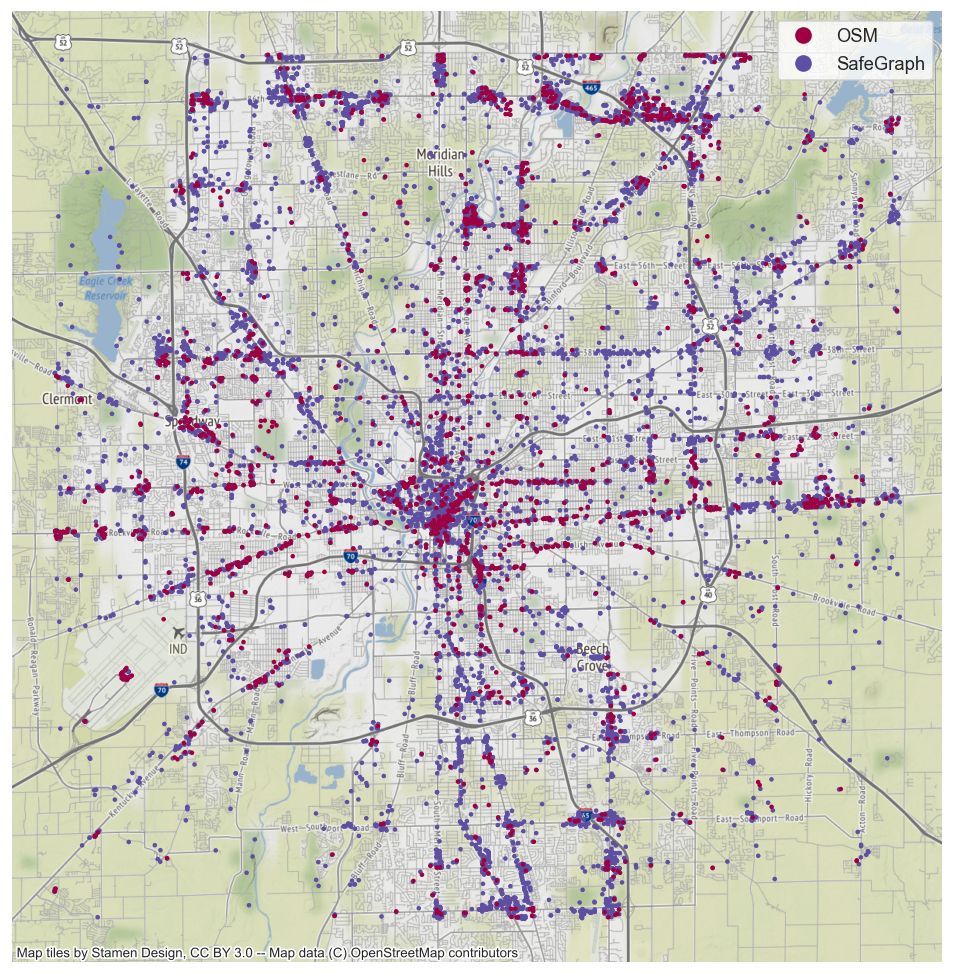

In [28]:
# t=0:07
ax = U.plot(size=(10, 16), dpi=120, axoff=1)
miny, minx = 39.63267237312068, -86.32849758648747
maxy, maxx = 39.92674817390339, -85.9540983877497
x2 = x.cx[minx: maxx, miny: maxy].to_crs(CRS_M)
x2.plot(ax=ax, column='source', cmap='Spectral', legend=True, markersize=3)
ctx.add_basemap(ax=ax, crs=CRS_M);

## POI accessibility

### Create road graph
Nearest neighbor matching based on this [StackExchange answer](https://gis.stackexchange.com/a/301935/220117)

In [29]:
def get_road_graph(interpolate_dist=100, save=True, overwrite=False):
    outfile = P.data / 'osm/poi_roads.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    pois = gpd.read_parquet(P.data / 'pois/pois.parquet').to_crs(CRS_M)
    xy_pois = mk.geo.gdf2pdf(pois)
    roads = (SP.read_parquet(P.data / 'osm/roads.parquet')
             .select(F.col('osm_id').alias('road_id'), 'fclass', 'geometry')
             .toPandas())
    roads = (Gdf(roads, geometry=gpd.GeoSeries.from_wkb(roads.geometry))
             .set_crs(CRS_DEG).to_crs(CRS_M))
    def get_dist(line): return np.arange(0, line.length, interpolate_dist)
    def get_pts(line):
        points = [line.interpolate(d) for d in get_dist(line)]
        endpoint = shapely.Point(line.coords[1])
        return points + [endpoint]
    roads['length'] = roads.geometry.length
    roads['pt'] = roads.geometry.apply(get_pts)
    roads['dist'] = roads.geometry.apply(lambda x: get_dist(x).tolist() + [x.length])
    nodes = Gdf(roads.set_index('road_id')[['pt', 'dist']].explode(['pt', 'dist'])
                .rename(columns={'pt': 'geometry'}).reset_index(), crs=CRS_M)
    xy_nodes = mk.geo.gdf2pdf(nodes)
    tree = cKDTree(xy_nodes.values)
    _, idx = tree.query(xy_pois.values)
    nodes = nodes.loc[np.unique(idx)].groupby('road_id').agg({'dist': set})
    nodes = (roads[['road_id', 'length', 'geometry']]
             .merge(nodes, on='road_id', how='left').fillna(''))
    nodes['dist'] = nodes['dist'].apply(set)
    nodes['dist'] = nodes.apply(lambda x: set([0., x['length']]).union(x['dist']), axis=1)
    nodes['pts'] = nodes.apply(lambda x: [x.geometry.interpolate(d) for d in x['dist']], axis=1)
    nodes['geometry'] = nodes['pts'].apply(lambda x: [
        shapely.LineString(pair) for pair in zip(x[:-1], x[1:])])
    edges = (Gdf(nodes[['road_id', 'geometry']].explode('geometry'), 
                 crs=CRS_M).rename_axis('eid').reset_index().to_crs(CRS_DEG))
    if save:
        edges.to_parquet(U.mkfile(outfile))
    return edges

x = get_road_graph().disp() # t=3:39

+---+-------+--------------------+
|eid|road_id|            geometry|
+---+-------+--------------------+
|  0|4450265|[01 02 00 00 00 0...|
+---+-------+--------------------+
only showing top 1 row



### Compute Euclidean reachability

In [30]:
tt_thresholds = np.arange(5, 60+1, 5) * 60

In [31]:
modal_speeds = {k: v * U.MI2M / 3600 for k, v in 
                {'Auto': 40, 'Transit': 25, 'Bike': 14, 'Walk': 3}.items()}

In [32]:
def get_reachability(scales, modal_speeds, tt_thresholds, 
                     metric='euclidean', save=True, overwrite=False):
    outfile = P.data / 'export/poi_reachability.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    assert metric in ['euclidean', 'road_network']
    pois = gpd.read_parquet(P.data / 'pois/pois.parquet').to_crs(CRS_M)
    res = []
    for scale in tqdm(scales):
        boundary = gpd.read_parquet(P.data / f'boundary/{scale.lower()}.parquet')
        zones = Gdf(boundary.set_index('geoid').to_crs(CRS_M)
                    .geometry.centroid.rename('centroid')
                    .rename('geometry').reset_index())
        for mode, speed in modal_speeds.items():
            for tt_thresh in tt_thresholds:
                radius = speed * tt_thresh
                buffers = Gdf(zones.buffer(radius).rename('geometry')
                              .rename_axis('geoid').reset_index())
                within = pois.sjoin(buffers, predicate='within')
                df = (within.groupby(['geoid', 'category']).size()
                      .rename('num_pois').reset_index()
                      .assign(scale=scale, mode=mode, tt_thresh=tt_thresh // 60))
                res.append(df)
    id_vars = ['scale', 'mode', 'tt_thresh', 'poi_kind', 'geoid']
    res = (pd.concat(res).reset_index(drop=True)
           .rename(columns={'category': 'poi_kind'})
           .astype({x: 'category' for x in id_vars})[id_vars + ['num_pois']]
           .rename(columns=str.upper))
    if save:
        res.to_parquet(U.mkfile(outfile))
    return res

%time x = get_reachability(scales[::-1], modal_speeds, tt_thresholds[::-1]); x # t=19:29

CPU times: user 2.4 ms, sys: 317 µs, total: 2.72 ms
Wall time: 238 ms


DataFrame[scale: string, mode: string, tt_thresh: bigint, poi_kind: string, geoid: bigint, num_pois: bigint]

# Miscellaneous

## LEHD/LODES

### Information

In [ ]:
lehd_info = {
    'LEHD': {
        'LODES': {
            'geography': {
                'crosswalk': {
                    'tabblk2010': '2010 Census Tabulation Block Code',
                    'st': 'FIPS State Code',
                    'stusps': 'USPS State Code',
                    'stname': 'State Name',
                    'cty': 'FIPS County Code',
                    'ctyname': 'County or County Equivalent Name',
                    'trct': 'Census Tract Code',
                    'trctname': 'Tract Name, formatted with County and State',
                    'bgrp': 'Census Blockgroup Code',
                    'bgrpname': 'Census Blockgroup Name, formatted with Tract, County, and State',
                    'cbsa': 'CBSA (Metropolitan/Micropolitan Area) Code',
                    'cbsaname': 'CBSA (Metropolitan/Micropolitan Area) Name',
                    'zcta': 'ZIP Code Tabulation Area (ZCTA) Code',
                    'zctaname': 'ZCTA Name',
                    'stplc': 'Nationally Unique Place Code, (FIPS State + FIPS Place)',
                    'stplcname': 'Place Name',
                    'ctycsub': 'Nationally Unique County Subdivision Code, (FIPS State + FIPS County + FIPS County Subdivision)',
                    'ctycsubname': 'County Subdivision Name',
                    'stcd116': 'Nationally Unique 116th Congressional District Code, (FIPS State + 2-digit District Number',
                    'stcd116name': '116th Congressional District Name',
                    'stsldl': 'Nationally Unique State Legislative District, Lower Chamber, (FIPS State + 3-digit District Number)',
                    'stsldlname': 'State Legislative District Chamber, Lower Chamber'
                }
            },
            'datasets': {
                'od': 'Origin-destination job flows',
                'rac': 'Residential area characteristics',
                'wac': 'Workplace area characteristics',
            },
            'job_types': {
                'JT00': 'All',
                'JT01': 'All Primary',
                'JT02': 'All Private',
                'JT03': 'Private Primary',
                'JT04': 'All Federal',
                'JT05': 'All Federal Primary',
            },
            'parts': {
                'main': 'Contains jobs with both workplace and residence in the state',
                'aux': 'Contains jobs with the workplace in the state and the residence outside of the state'
            },
            'segments': {
                'S000': 'Total number of jobs',
                'SA01': 'Number of jobs of workers age 29 or younger',
                'SA02': 'Number of jobs for workers age 30 to 54',
                'SA03': 'Number of jobs for workers age 55 or older',
                'SE01': 'Number of jobs with earnings $1250/month or less',
                'SE02': 'Number of jobs with earnings $1251/month to $3333/month',
                'SE03': 'Number of jobs with earnings greater than $3333/month',
                'SI01': 'Number of jobs in Goods Producing industry sectors',
                'SI02': 'Number of jobs in Trade, Transportation, and Utilities industry sectors',
                'SI03': 'Number of jobs in All Other Services industry sectors',
            },
            'variables': {
                'C000': 'Total number of jobs',
                'CA01': 'Number of jobs for workers age 29 or younger',
                'CA02': 'Number of jobs for workers age 30 to 54',
                'CA03': 'Number of jobs for workers age 55 or older',
                'CE01': 'Number of jobs with earnings $1250/month or less',
                'CE02': 'Number of jobs with earnings $1251/month to $3333/month',
                'CE03': 'Number of jobs with earnings greater than $3333/month',
                'CNS01': 'Number of jobs in NAICS sector 11 (Agriculture, Forestry, Fishing and Hunting)',
                'CNS02': 'Number of jobs in NAICS sector 21 (Mining, Quarrying, and Oil and Gas Extraction)',
                'CNS03': 'Number of jobs in NAICS sector 22 (Utilities)',
                'CNS04': 'Number of jobs in NAICS sector 23 (Construction)',
                'CNS05': 'Number of jobs in NAICS sector 31-33 (Manufacturing)',
                'CNS06': 'Number of jobs in NAICS sector 42 (Wholesale Trade)',
                'CNS07': 'Number of jobs in NAICS sector 44-45 (Retail Trade)',
                'CNS08': 'Number of jobs in NAICS sector 48-49 (Transportation and Warehousing)',
                'CNS09': 'Number of jobs in NAICS sector 51 (Information)',
                'CNS10': 'Number of jobs in NAICS sector 52 (Finance and Insurance)',
                'CNS11': 'Number of jobs in NAICS sector 53 (Real Estate and Rental and Leasing)',
                'CNS12': 'Number of jobs in NAICS sector 54 (Professional, Scientific, and Technical Services)',
                'CNS13': 'Number of jobs in NAICS sector 55 (Management of Companies and Enterprises)',
                'CNS14': 'Number of jobs in NAICS sector 56 (Administrative and Support and Waste Management and Remediation Services)',
                'CNS15': 'Number of jobs in NAICS sector 61 (Educational Services)',
                'CNS16': 'Number of jobs in NAICS sector 62 (Health Care and Social Assistance)',
                'CNS17': 'Number of jobs in NAICS sector 71 (Arts, Entertainment, and Recreation)',
                'CNS18': 'Number of jobs in NAICS sector 72 (Accommodation and Food Services)',
                'CNS19': 'Number of jobs in NAICS sector 81 (Other Services [except Public Administration])',
                'CNS20': 'Number of jobs in NAICS sector 92 (Public Administration)',
                'CR01': 'Number of jobs for workers with Race: White, Alone',
                'CR02': 'Number of jobs for workers with Race: Black or African American Alone',
                'CR03': 'Number of jobs for workers with Race: American Indian or Alaska Native Alone',
                'CR04': 'Number of jobs for workers with Race: Asian Alone',
                'CR05': 'Number of jobs for workers with Race: Native Hawaiian or Other Pacific Islander Alone',
                'CR07': 'Number of jobs for workers with Race: Two or More Race Groups',
                'CT01': 'Number of jobs for workers with Ethnicity: Not Hispanic or Latino',
                'CT02': 'Number of jobs for workers with Ethnicity: Hispanic or Latino',
                'CD01': 'Number of jobs for workers with Educational Attainment: Less than high school',
                'CD02': 'Number of jobs for workers with Educational Attainment: High school or equivalent, no college',
                'CD03': 'Number of jobs for workers with Educational Attainment: Some college or Associate degree',
                'CD04': 'Number of jobs for workers with Educational Attainment: Bachelors degree or advanced degree',
                'CS01': 'Number of jobs for workers with Sex: Male',
                'CS02': 'Number of jobs for workers with Sex: Female',
            }
        }
    }
}

### Download data

In [ ]:
def download_lehd_lodes(dataset='od', job_type='JT00', state='in', part='main',
                        segment='S000', year=2019, lodes_version=7,
                        aggregate_bg=False, save=True, overwrite=False):
    assert lodes_version in [6, 7]
    assert dataset in ['od', 'rac', 'wac']
    assert part in ['main', 'aux']
    assert job_type in [f'JT{i:02}' for i in range(6)]
    assert segment in 'S000 SA01 SA02 SA03 SE01 SE02 SE03 SI01 SI02 SI03'.split()
    outfile = P.data / f'lehd/lodes/{dataset}.parquet'
    if outfile.exists() and not overwrite: return
    root = f'https://lehd.ces.census.gov/data/lodes'
    fname = {'od': f'{state}_od_{part}_{job_type}_{year}',
            'rac': f'{state}_rac_{segment}_{job_type}_{year}',
            'wac': f'{state}_wac_{segment}_{job_type}_{year}'}[dataset]
    url = f'{root}/LODES{lodes_version}/{state}/{dataset}/{fname}.csv.gz'
    df = pd.read_csv(url).drop(columns='createdate', errors='ignore')
    idx_cols = {'od': ['h_geocode', 'w_geocode'],
                'rac': ['h_geocode'], 'wac': ['w_geocode']}[dataset]
    df = df.astype({col: str for col in idx_cols})
    if aggregate_bg:
        for col in idx_cols:
            df[col] = df[col].str.slice(0, 12)
        df = df.groupby(idx_cols).sum().reset_index()
    if save:
        df.to_parquet(U.mkfile(outfile))
    return df

download_lehd_lodes('od') # t=0:17
download_lehd_lodes('rac') # t=0:05
download_lehd_lodes('wac') # t=0:03

## Economic Tracker
GitHub: https://github.com/OpportunityInsights/EconomicTracker

In [ ]:
def download_oi_ecotracker_data(overwrite=False):
    url = 'https://github.com/OpportunityInsights/EconomicTracker/archive/main.zip'
    outfile = P.data / 'economic_tracker/raw_data.zip'
    if outfile.exists() and not overwrite:
        return
    urllib.request.urlretrieve(url, U.mkfile(outfile))

x = download_oi_ecotracker_data(); x # t=0:22